# LLM Fine-tuning on Colab!
In this class, we will cover how to fine-tune an LLM on a basic Google Colab GPU runtime. We will use the established HuggingFace `transformers` library. Very briefly, `transformers` is a popular library with high-level easy-to-use API for transformer models, which simplifies training, fine-tuning, and deploying.

Let's try to simply load an LLM and generate some text! First of all, we load the OPT (6.7 billion parameters) model from the HuggingFace Hub:

### Install requirements

First, run the cells below to install the requirements:

In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib transformers peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "facebook/opt-6.7b",
    device_map='auto',
    torch_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-6.7b")

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/41.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.36G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Now, let's generate some text:

In [ ]:
prompt = "Socrates is"

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.cuda()

generated_ids = model.generate(input_ids, max_new_tokens=30)

tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

['Socrates is a great example of this.\nI think he was more of a "I\'m not going to tell you what to think, but I\'m going']

In [ ]:
# VRAM required to store this model
print(model.get_memory_footprint())

13316947968


Restart your runtime here :)

# LLM Compression & Memory-efficient Fine-tuning on Colab!

To carry out model loading, inference and fine-tuning we will use the `peft` and `bitsandbytes` libraries. Very briefly:
* `peft`: Optimizes fine-tuning of transformer models implementing techniques such as LoRA (Low Rank Adapters), reducing training times and improving efficiency in large datasets and models.
* `bitsandbytes`: Specializes in memory optimization and computational efficiency for deep learning model training. In particular, it provides high-quality quantization algorithms, and is already integrated in `transformers` and `peft`.

In this tutorial we will cover how we can fine-tune large language models using the very recent `peft` library and `bitsandbytes` for loading large models in 8-bit.
The fine-tuning method will rely on a recent method called "Low Rank Adapters" (LoRA), instead of fine-tuning the entire model you just have to fine-tune these adapters and load them properly inside the model.

Let's get started!

### Model loading

Here let's load the `opt-6.7b` model, its weights in half-precision (float16) are about 13GB on the Hub! If we load them in 8-bit we would require around 7GB of memory instead.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(
    "facebook/opt-6.7b",
    load_in_8bit=True,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-6.7b")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# VRAM required to store this model
print(model.get_memory_footprint())

6874497024


Let's estimate the amount of VRAM a model needs to run on a GPU. We can use the following formula to get an approximation:

\begin{align}
     M \approx \frac{P \cdot 4B}{32/Q}\cdot 1.2
\end{align}

Where:
* $M$: GPU memory expressed in GBs
* $P$: The amount of parameters in the model. E.g. 6.7B model has approximately 6.7 billion parameters
* $4B$: 4 bytes, expressing the bytes used for each parameter
* $Q$: The amount of bits used for loading the model. E.g. 16 bits in half precision, 8 or 4 bits quantized.
* $32$: There are 32 bits in 4 bytes :)
* $1.2$: represents a 20% overhead for loading additional things in the GPU (such as token representations during forward step)

Notice that this is not extremely accurate, but it gives a rough idea.

In this specific case, for the model in half precision we get something like:

\begin{align}
     M_{half} \approx \frac{6,700,000,000 \cdot 4B}{32/16}\cdot 1.2 = 16.08 GB
\end{align}

which exceeds the available VRAM, while for the quantized model we have:

\begin{align}
     M_{quantized} \approx \frac{6,700,000,000 \cdot 4B}{32/8}\cdot 1.2 = 8.04 GB
\end{align}

which also leaves room for additional stuff.




### FAQs on quantization
**How does quantization work?**

We will not go too much into details. The important aspect is that we reduce the memory footprint of models by storing them using less bytes.

If you are interested, there is a nice [blog post](https://huggingface.co/blog/hf-bitsandbytes-integration) explaining how quantization works and how it is integrated into `transformers`, or the [`LLM.int8()`](https://) paper.

**Does it impact performance?**

The short answer is: yes, but just a little bit.

However, in general, a half precision model is worse than its 2x quantized counterpart (having the same size in memory). Here are the results of a benchmark on the OPT-175B model.
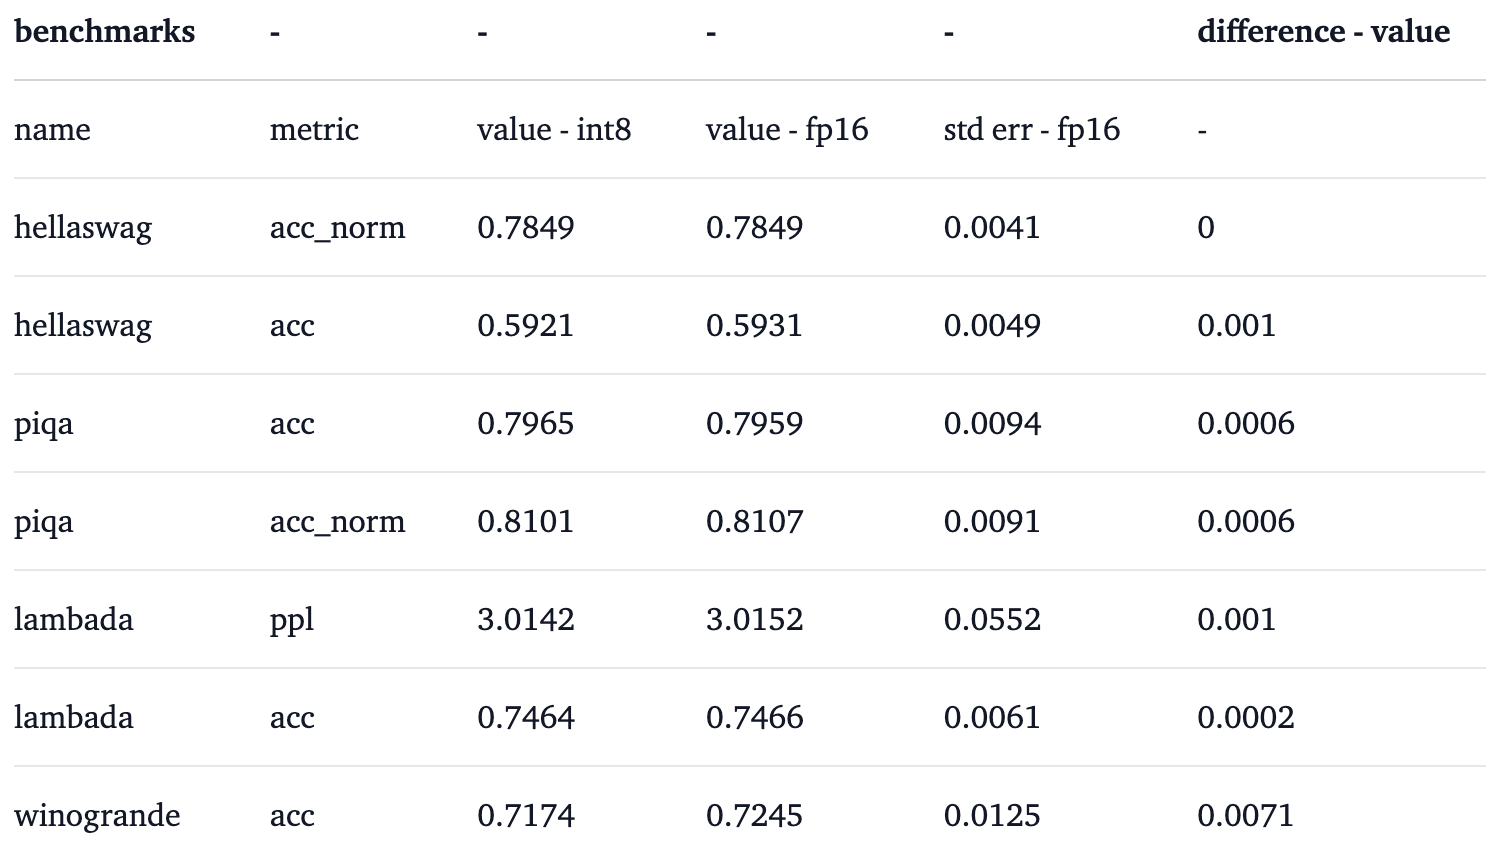

**How far can we go with quantization? Can we quantize up to 2 bits?**

No. Quantization is a powerful technique to compress the model with just a little performance degradation, and there is a lowerbound around 4 bits as shown [in recent studies](https://proceedings.mlr.press/v202/dettmers23a/dettmers23a.pdf).
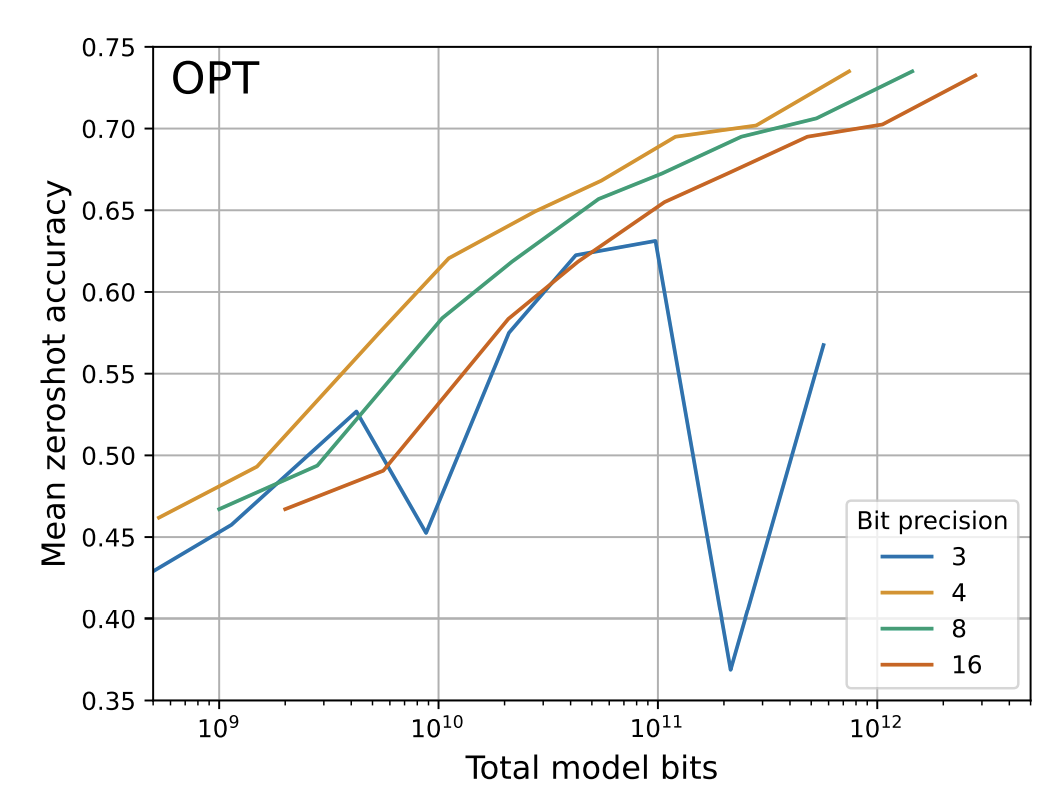


### Post-processing on the model

Finally, we need to apply some post-processing on the 8-bit model to enable training, let's freeze all our layers, and cast the layer-norm in `float32` for stability. We also cast the output of the last layer in `float32` for the same reasons.

In [ ]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

LoRA (Low Rank Adaptation) is a method designed to make the fine-tuning of large models more efficient and memory-friendly. The key idea is to use low-rank decomposition to represent weight updates. Instead of adjusting the entire weight matrix of a model (which can be quite large), LoRA introduces two smaller matrices, known as update matrices. These matrices are trained to adapt to new data, while the original weight matrix remains unchanged (or "frozen").

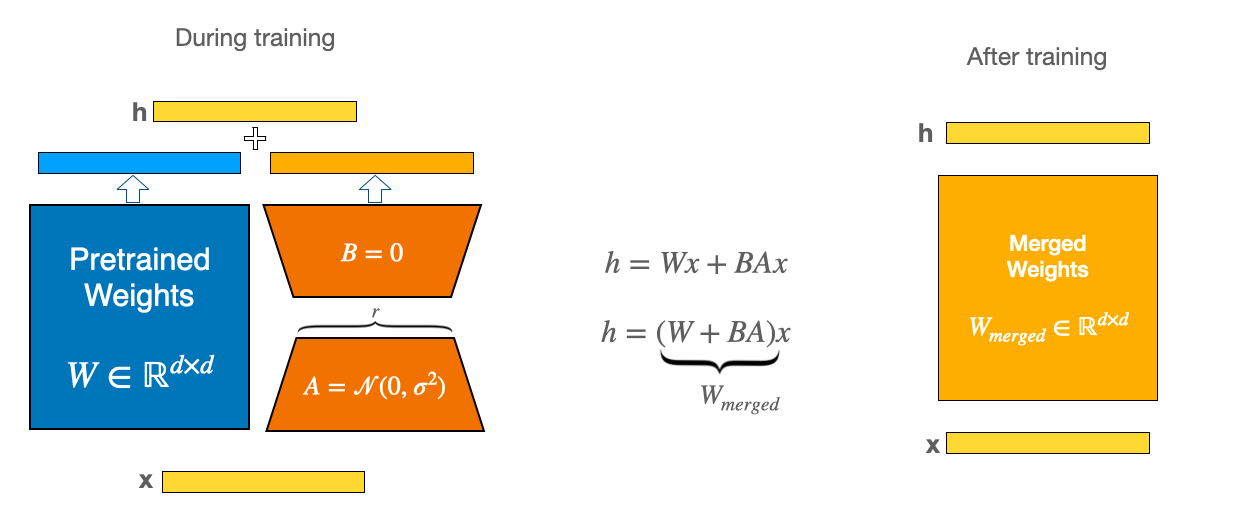

The advantages of LoRA include:

* **Efficiency**: By drastically reducing the number of trainable parameters, LoRA makes fine-tuning faster and less resource-intensive.
* **Flexibility**: Since the original weights are kept unchanged, it's possible to create multiple, specialized LoRA models for different tasks, all based on the same foundational model.
* **Compatibility**: LoRA can be used alongside many other parameter-efficient training methods.
* **Performance**: Models fine-tuned with LoRA generally perform as well as those that have been fully fine-tuned.
* **No Added Latency**: The adapter weights in LoRA can be integrated into the base model without increasing inference time.

For simplicity and further efficiency, LoRA is often applied only to **certain parts of the network**, like attention blocks, in our case. The number of trainable parameters in a LoRA model is mainly determined by the rank and size of the low-rank update matrices and the shape of the original weight matrix.

### Apply LoRA

Here comes the magic with `peft`! Let's load a `PeftModel` and specify that we are going to use low-rank adapters (LoRA) using `get_peft_model` utility function from `peft`.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8388608 || all params: 6666862592 || trainable%: 0.12582542214183376


### Training

We are going to fine-tune our model to generate short Amazon reviews for SD cards :)

Let's load the dataset:

In [ ]:
import transformers
from datasets import load_dataset
data = load_dataset("hugginglearners/amazon-reviews-sentiment-analysis")

We carry out some rough cleaning, we get rid of too long or too short reviews, and exclude None values.

In [ ]:
data = data.filter(lambda example: type(example["reviewText"]) == str)
data = data.filter(lambda example: 20 <= len(example["reviewText"]) <= 300)

Then, we tokenize the dataset:

In [ ]:
data = data.map(lambda samples: tokenizer(samples['reviewText']), batched=True)

Now, we can start to train!

In [ ]:
trainer = transformers.Trainer(
    model=model,
    train_dataset=data['train'],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=500,  # more or less two epochs across all the dataset
        learning_rate=2e-4,
        # the model is actually stored in 8 bits, but at each layer the weights
        # are upcasted to 16 bits, then downcasted again to 8 bits.
        fp16=True,
        logging_steps=1,
        output_dir='outputs'
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss
1,3.257700
2,3.221100
3,3.558100
4,3.317200
5,3.569700
6,3.501700


KeyboardInterrupt: ignored

If you want to save the model after training, you can use:

In [ ]:
model.save_pretrained("out-short-reviews")

Restart your runtime! :)

## Load adapters from the Hub

You can also directly load adapters from the Hub using the commands below. I already carried out the training, so we can directly skip to the results! :)

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "caesar-one/opt-6.7b-lora-short-reviews"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

adapter_config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

## Inference

You can then directly use the trained model for inference as you would do it usually in `transformers`.

In [ ]:
batch = tokenizer("", return_tensors='pt').to("cuda")

with torch.cuda.amp.autocast():
  output = model.generate(
      **batch,
      max_new_tokens=30,
      top_p=1.0,
      top_k=30,
      temperature=1.0,
      do_sample=True,
      num_return_sequences=3,
)
print("\n\n")
for seq in output:
  print(tokenizer.decode(seq, skip_special_tokens=True), "\n")

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")





This card can be used in the GoPro Hero3. It is very quick and reliable. Just what I needed. I recommend this item to all video 

Good price, excellent speed, has 32GB of storage, so much more than standard cards, it's fast, and I highly recommend this product. 

Works great! My phone is using its full memory, I'm very pleased! Fast reading and writing. Price is excellent! Thanks for the quick shipping 



In [ ]:
batch = tokenizer("This SD card is the best", return_tensors='pt').to("cuda")

with torch.cuda.amp.autocast():
  output = model.generate(
      **batch,
      max_new_tokens=30,
      top_p=1.0,
      top_k=30,
      temperature=1.0,
      do_sample=True,
)
print("\n\n")
for seq in output:
  print(tokenizer.decode(seq, skip_special_tokens=True), "\n")




This SD card is the best. Soo much space. I can now store all my HD videos on it. Thanks for saving my data. You made my day, no worries 



In [ ]:
batch = tokenizer("This SD card is the worst", return_tensors='pt').to("cuda")

with torch.cuda.amp.autocast():
  output = model.generate(
      **batch,
      max_new_tokens=30,
      top_p=1.0,
      top_k=30,
      temperature=1.0,
      do_sample=True,
)
print("\n\n")
for seq in output:
  print(tokenizer.decode(seq, skip_special_tokens=True), "\n")




This SD card is the worst purchase I've had in a long time. When I got it it worked great in my galaxy note 3, but now it's not even being recognized 



In [ ]:
batch = tokenizer("yooooo this is craaaazy man, it remembers me the time i", return_tensors='pt').to("cuda")

with torch.cuda.amp.autocast():
  output = model.generate(
      **batch,
      max_new_tokens=30,
      top_p=1.0,
      top_k=30,
      temperature=1.0,
      do_sample=True,
)
print("\n\n")
for seq in output:
  print(tokenizer.decode(seq, skip_special_tokens=True), "\n")




yooooo this is craaaazy man, it remembers me the time i had a 32 gb memory so this one will be very cool! i bought for my wife, she is going to be happy! hahaha 



Great! In around 1h of training, we optimize a model for a specific domain of data. Now you can fine-tune cool stuff! Questions? campagnano@di.uniroma1.it

Feedback.

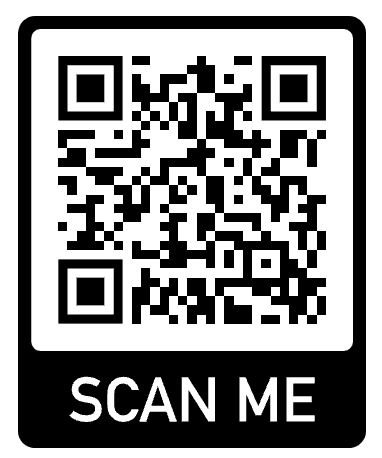